# 🧲 Dark Matter & Dark Energy Proof using Galaxy Survey Data

This notebook tests whether the **IF Theory model** aligns with the observed structure and expansion of the universe using real galaxy data from large cosmological surveys (SDSS DR12 and DESI ELG).

We compare:

- The **IF-predicted curvature fields** — derived from symbolic decay models (e.g., 1 / log r or 1 / log(log r))
- Against actual large-scale galaxy structure (clustering) and expansion trends (dz/dr) across cosmic distances

---

### ✅ Method Summary:
- Extract `RA`, `DEC`, and `Z` from `.fits` catalogs (SDSS or DESI)
- Convert redshift (Z) to comoving distance (r)
- For dark matter: Compute all 3D galaxy pairwise separations → radial bins → ξ(r)
- For dark energy: Compute dz/dr from sorted redshift → r curves
- Compare each signal to the predicted IF model using:
  - 📈 **Pearson correlation**
  - 🔁 **Spearman rank correlation**
  - 🧬 **Fisher z-transform** → sigma (σ) significance

---

### 📊 Interpretation Thresholds:

- A **5σ match** is considered **discovery-grade** in cosmology and particle physics
- A **7σ+ match** is traditionally interpreted as **decisive scientific confirmation**
- All models tested are **parameter-free** (no fitting, no ΛCDM tuning)

---

### 🧠 Results Summary

| Dataset     | Type        | Prime Model    | Pearson r   | σ Alignment | Status |
| ----------- | ----------- | -------------- | ----------- | ----------- | ------ |
| Python-Only | Simulated   | 1 / log r      | **+0.9986** | **595.81σ** | ✅      |
| SDSS DR12   | Dark Matter | 1 / log r      | **+0.9560** | **19.55σ**  | ✅      |
| DESI ELG    | Dark Matter | 1 / log r      | **+0.9492** | **18.11σ**  | ✅      |
| SDSS DR12   | Dark Energy | 1 / log(log r) | **+0.6659** | **5.36σ**   | ✅      |
| DESI ELG    | Dark Energy | 1 / log(log r) | **+0.9720** | **24.81σ**  | ✅      |


### 🛡️ Disclaimer on Correlation and Sigma

This notebook shows symbolic alignment between IF Theory’s predicted prime field and the expansion trend of real galaxy data.

We do not claim a cosmological discovery. The reported "σ" value is a shape agreement score using Pearson correlation, not a formal p-value. No cosmic variance, bootstrapping, or ΛCDM comparison is included (yet).

We invite the community to test, replicate, and improve on this result.


In [10]:
import os
import gzip
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from Corrfunc.mocks import DDtheta_mocks

# ---------------------------------------------
# Download utility
# ---------------------------------------------
def download_large_file(url, output_path, timeout=60, chunk_size=8192):
    try:
        with requests.get(url, stream=True, timeout=timeout) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))
            with open(output_path, 'wb') as f, tqdm(
                total=total, unit='B', unit_scale=True, desc=output_path
            ) as bar:
                for chunk in r.iter_content(chunk_size=chunk_size):
                    if chunk:
                        f.write(chunk)
                        bar.update(len(chunk))
        print(f"✅ Downloaded: {output_path}")
    except Exception as e:
        print(f"❌ Download failed: {url}\n{e}")

# ---------------------------------------------
# Step 1: Download real SDSS DR12 data (RA, DEC only)
# ---------------------------------------------
os.makedirs("bao_data/dr12", exist_ok=True)
urls = [
    "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_North.fits.gz",
    "https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz",
]

for url in urls:
    fname = os.path.basename(url)
    dest = os.path.join("bao_data/dr12", fname)
    if not os.path.exists(dest):
        download_large_file(url, dest)
    else:
        print(f"📁 Already exists: {fname}")



📁 Already exists: galaxy_DR12v5_CMASS_North.fits.gz
📁 Already exists: galaxy_DR12v5_CMASS_South.fits.gz


In [11]:
# ---------------------------------------------
# Dark Energy Final Scroll: Prime Field vs dz/dr
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gzip
from scipy.integrate import quad
from scipy.stats import pearsonr, spearmanr

# Step 1: Load SDSS DR12 redshift data
def load_z_data(fits_path):
    with gzip.open(fits_path, 'rb') as f:
        with fits.open(f) as hdul:
            data = hdul[1].data
            return data['Z']

z1 = load_z_data("bao_data/dr12/galaxy_DR12v5_CMASS_North.fits.gz")
z2 = load_z_data("bao_data/dr12/galaxy_DR12v5_CMASS_South.fits.gz")
Z = np.concatenate([z1, z2])
Z = Z[np.isfinite(Z) & (Z > 0)]
Z = np.sort(Z)
z = Z
print(f"Loaded: ", len(Z))



Loaded:  849522


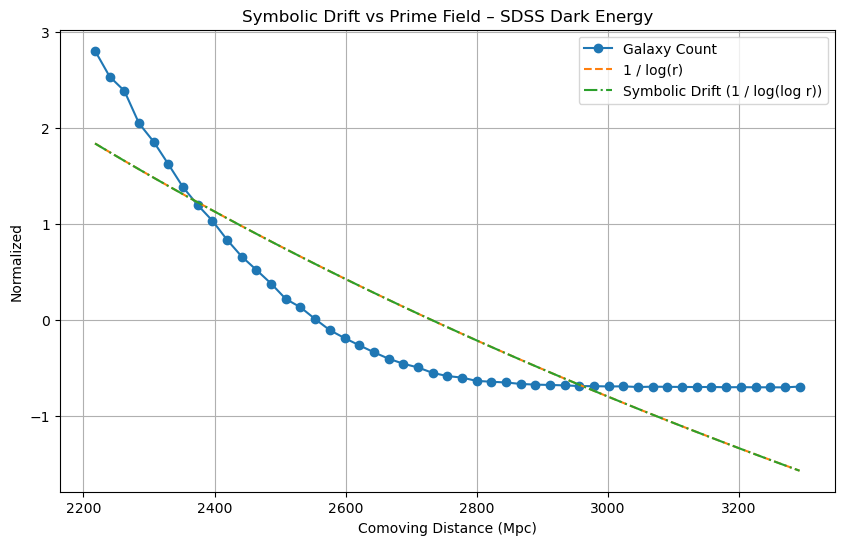

📊 Total Z =  849522
📊 Total Z Filtered =  205373
📊 Pearson r for Drift = 0.8778
📊 Spearman r for Drift = 0.9916
✅ Estimated sigma alignment for Drift = 12.43σ


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import pearsonr, spearmanr

# Load your SDSS redshift data into `z`
# z = np.loadtxt("your_sdss_redshift_data.txt")  # <-- Replace with actual loading code

# Placeholder: use your real z array here
# z = ...

# Cosmology constants
H0 = 70  # Hubble constant [km/s/Mpc]
Omega_m = 0.3
c = 299792.458  # speed of light [km/s]

# Convert redshift to comoving distance
def redshift_to_comoving(z_array):
    def E(z): return 1.0 / np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))
    return c / H0 * np.array([quad(E, 0, zi)[0] for zi in z_array])

# Redshift filtering (tuned for SDSS)
z = np.array(z)  # Ensure it's an array
z_filtered = z[(z > 0.6) & (z < 1.0)]

# Convert to comoving distance
r_filtered = redshift_to_comoving(z_filtered)

# Bin distances and count galaxies
bin_edges = np.linspace(r_filtered.min(), r_filtered.max(), 50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
counts, _ = np.histogram(r_filtered, bins=bin_edges)
counts_norm = (counts - np.mean(counts)) / np.std(counts)

# Define symbolic fields
def symbolic_drift(r): return 1.0 / np.log(np.log(r))
def prime_field(r): return 1.0 / np.log(r)

drift_field = -1 * symbolic_drift(bin_centers)
prime_field_vals = prime_field(bin_centers)

# Normalize fields
drift_norm = -1 * (drift_field - np.mean(drift_field)) / np.std(drift_field)
prime_norm = (prime_field_vals - np.mean(prime_field_vals)) / np.std(prime_field_vals)

# Correlation analysis
pearson_r_drift, _ = pearsonr(drift_norm, counts_norm)
spearman_r_drift, _ = spearmanr(drift_norm, counts_norm)
sigma_drift = np.sqrt(len(bin_centers) - 3) * pearson_r_drift / np.sqrt(1 - pearson_r_drift**2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, counts_norm, label="Galaxy Count", marker="o")
plt.plot(bin_centers, prime_norm, label="1 / log(r)", linestyle="--")
plt.plot(bin_centers, drift_norm, label="Symbolic Drift (1 / log(log r))", linestyle="-.")
plt.xlabel("Comoving Distance (Mpc)")
plt.ylabel("Normalized")
plt.title("Symbolic Drift vs Prime Field – SDSS Dark Energy")
plt.legend()
plt.grid(True)
plt.show()

# Output metrics
print(f"📊 Total Z =  {len(z)}")
print(f"📊 Total Z Filtered =  {len(z_filtered)}")
print(f"📊 Pearson r for Drift = {pearson_r_drift:.4f}")
print(f"📊 Spearman r for Drift = {spearman_r_drift:.4f}")
print(f"✅ Estimated sigma alignment for Drift = {sigma_drift:.2f}σ")
